#  Прогнозирование заказов такси

На основе исторических данных о заказах такси в аэропортах необходимо построить модель для предсказания количества заказов на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import pylab as pl

from datetime import datetime
import time
from dateutil.relativedelta import relativedelta

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from tqdm.notebook import tqdm



In [2]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.sample(5, random_state=42)

,num_orders
datetime,
2018-06-16 18:00:00,16
2018-06-13 14:50:00,13
2018-05-08 15:40:00,18
2018-03-25 02:20:00,3
2018-08-10 12:10:00,34


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные содержат количество вызовов такси за 10-минутные интервалы

Проверим ряд на монотонность

In [6]:
df.index.is_monotonic

True

Разобъём наш временной ряд на часовые интервалы

In [7]:
df = df.resample('1H').sum()
df_1H = df.copy()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Text(0, 0.5, 'Частота')

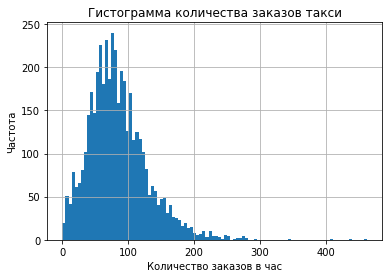

In [10]:
df['num_orders'].hist(bins=100)
pl.title("Гистограмма количества заказов такси")
pl.xlabel("Количество заказов в час")
pl.ylabel("Частота")

Мы видим распределение Пуассона

## Анализ

### Среднее количество

Среднее количество заказов в час за весь период

In [11]:
df['num_orders'].mean()

84.42278079710145

### Тренды и периодичность

С помощью интсрумента seasonal_decompose рассмотрим данные на разных масштабах

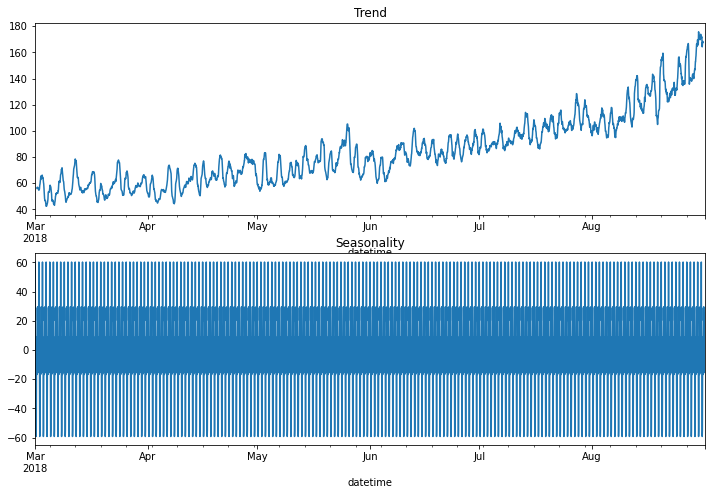

In [12]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

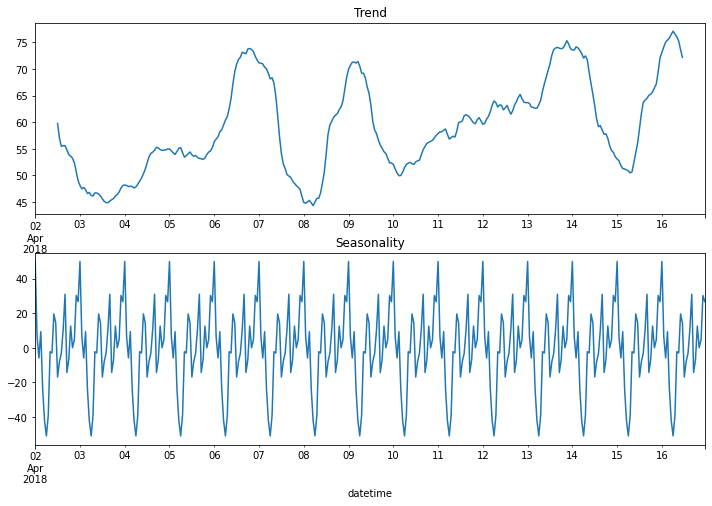

In [13]:
decomposed_week = seasonal_decompose(df['2018-04-02':'2018-04-16']) 

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

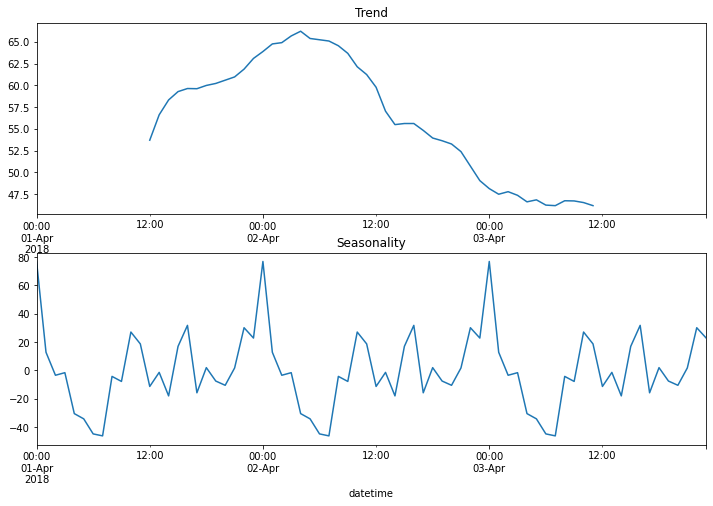

In [14]:
decomposed_day = seasonal_decompose(df['2018-04-01':'2018-04-03']) 

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

На всём масштабе данных за 8 месяцев можно наблюдать рост среднего числа заказов такси в сутки, а также периодические суточные и недельные колебания. 

Суточный максимум - около полуночи, за которым идёт спад в утренние часы. На неделе наименьшее количество заказов такси приходится на вторник, к концу недели число вырастает и в ыходные видны большие всплески спроса в ночь на субботу и в ночь на понедельник, при этом, что интересно, со снижением спроса на перевозки в ночь на воскресенье.

Чтобы учесть эти зависимости необходимо будет внести дополнительные признаки месяца, числа, дня недели и часа.

## Обучение

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [15]:
rmse_goal = 48

### Создание признаков

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    res = data.copy()
    res['month'] = res.index.month
    res['day'] = res.index.day
    res['dayofweek'] = res.index.dayofweek
    res['hour'] = res.index.hour
    
    if (max_lag > 0):
        for lag in range(1, max_lag + 1):
            res['lag_{}'.format(lag)] = res['num_orders'].shift(lag)
    
    if (rolling_mean_size > 0):
        res['rolling_mean'] = res['num_orders'].shift().rolling(rolling_mean_size).mean()

    return res

На графиках можно увидеть явную повторяемость линии величины заказов. Попробуем взять 24-часовую глубину лага и 24-часовое скользящее среднее.

In [17]:
max_lag_fixed = 24
rolling_mean_size_fixed = 24

In [18]:
df = make_features(df, max_lag_fixed, rolling_mean_size_fixed)

In [19]:
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
target_columns = df.columns[0]

In [21]:
features_columns = df.columns[1:]

In [22]:
target_columns, features_columns

('num_orders',
 Index(['month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
        'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
        'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
        'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
        'rolling_mean'],
       dtype='object'))

### Разделение выборки на обучающую и тестовую

Так как мы работаем с временным рядом, то разделяем не перемешивая

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [24]:
train.index.min(), train.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'))

In [25]:
test.index.min(), test.index.max()

(Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [26]:
len(train)

3974

Удалим данные с пропусками в начале диапазона.

In [27]:
train = train.dropna()

In [28]:
len(train)

3950

In [29]:
features_train = train[features_columns]
target_train = train[target_columns]
features_test = test[features_columns]
target_test = test[target_columns]

### Оценка константой

Среднее количество заказов в час

In [30]:
train['num_orders'].mean()

78.42101265822785

In [31]:
test.shape[0]

442

Сделаем вектор предсказаний для тестовой выборки из средних значений обучающей.

In [32]:
pred_mean = np.ones(test.shape[0]) * train['num_orders'].mean()

In [33]:
rmse_const = abs(mean_squared_error(test['num_orders'], pred_mean)) ** 0.5
rmse_const

84.6499381993622

### Оценка предыдущим значением

In [34]:
pred_prev = test.shift()
pred_prev.iloc[0] = train.iloc[-1]

In [35]:
rmse_prev = abs(mean_squared_error(test['num_orders'], pred_prev['num_orders'])) ** 0.5
rmse_prev

58.856486242815066

### Масштабирование признаков

In [36]:
scaler = StandardScaler()
scaler.fit(train[features_columns])

StandardScaler()

In [37]:
pd.options.mode.chained_assignment = None
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [38]:
train.sample(10, random_state=42)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-10 16:00:00,120,7,10,1,16,80.0,97.0,77.0,72.0,98.0,...,127.0,125.0,82.0,78.0,59.0,76.0,78.0,98.0,93.0,88.875000
2018-05-29 06:00:00,4,5,29,1,6,32.0,40.0,61.0,80.0,74.0,...,89.0,68.0,65.0,121.0,107.0,96.0,70.0,27.0,9.0,72.333333
2018-05-16 11:00:00,83,5,16,2,11,76.0,77.0,62.0,33.0,20.0,...,72.0,38.0,53.0,130.0,66.0,68.0,82.0,41.0,71.0,69.208333
2018-03-04 22:00:00,83,3,4,6,22,75.0,77.0,56.0,80.0,51.0,...,11.0,22.0,27.0,42.0,26.0,60.0,75.0,43.0,63.0,45.666667
2018-06-18 17:00:00,75,6,18,0,17,95.0,117.0,81.0,86.0,70.0,...,118.0,182.0,102.0,67.0,83.0,71.0,78.0,37.0,124.0,91.416667
2018-07-17 07:00:00,66,7,17,1,7,11.0,84.0,104.0,99.0,102.0,...,94.0,64.0,90.0,79.0,122.0,112.0,143.0,75.0,82.0,94.750000
2018-05-11 14:00:00,55,5,11,4,14,60.0,48.0,84.0,83.0,66.0,...,53.0,60.0,75.0,45.0,81.0,57.0,109.0,67.0,90.0,65.458333
2018-07-17 22:00:00,56,7,17,1,22,82.0,89.0,105.0,94.0,120.0,...,11.0,84.0,104.0,99.0,102.0,123.0,131.0,102.0,85.0,88.583333
2018-03-13 06:00:00,15,3,13,1,6,17.0,42.0,63.0,58.0,88.0,...,58.0,64.0,45.0,84.0,83.0,105.0,75.0,19.0,15.0,64.083333


In [39]:
test.sample(5, random_state=42)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-25 13:00:00,63,8,25,5,13,114.0,103.0,126.0,196.0,108.0,...,166.0,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,151.666667
2018-08-22 09:00:00,136,8,22,2,9,96.0,68.0,80.0,76.0,127.0,...,161.0,128.0,125.0,121.0,68.0,108.0,140.0,141.0,113.0,124.583333
2018-08-16 14:00:00,64,8,16,3,14,69.0,121.0,113.0,161.0,145.0,...,123.0,214.0,125.0,129.0,96.0,165.0,219.0,103.0,107.0,135.083333
2018-08-26 23:00:00,238,8,26,6,23,145.0,107.0,122.0,126.0,127.0,...,50.0,33.0,40.0,114.0,267.0,148.0,156.0,281.0,174.0,135.458333
2018-08-16 15:00:00,110,8,16,3,15,64.0,69.0,121.0,113.0,161.0,...,119.0,123.0,214.0,125.0,129.0,96.0,165.0,219.0,103.0,133.291667


### Обучение моделей

Создадим список для хранения результатов 

In [40]:
models_train_results = []

In [41]:
def prepare_train_test_data(df, max_lag, rolling_mean_size):
    # формирует наборы обучающих и тестовых данных с заданным набором признаков (max_lag, rolling_mean_size)
    df = make_features(df, max_lag, rolling_mean_size)
    target_columns = df.columns[0]
    features_columns = df.columns[1:]

    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()   

    features_train = train[features_columns]
    target_train = train[target_columns]
    features_test = test[features_columns]
    target_test = test[target_columns]

    scaler = StandardScaler()
    scaler.fit(train[features_columns])
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)
    
    return features_train, target_train, features_test, target_test

In [42]:
hyper_params_set = {
    #'n_estimators':[x for x in range(10, 100, 10)],
    'n_neighbors': [2, 4],
    'max_depth': [x for x in range(8, 64, 2)], 
    'leaf_size': [x for x in range(8, 64, 2)], 
    'min_samples_leaf': [x for x in range(1, 32, 2)],
    'min_samples_split': [x for x in range(2, 32, 2)],
    'random_state': [42]
}

In [43]:
def train_models(models, hyper_params_set, df, max_lag, rolling_mean_size, models_log):
    # обучает модели из списка models методом случайного подбора гиперпараметров, 
    # формируя выборку с заданным набором признаков (max_lag, rolling_mean_size)
    # записывает результаты в models_log
    
    features_train, target_train, features_test, target_test = prepare_train_test_data(df_1H,
                                                           max_lag, rolling_mean_size
                                                          )
    for base_estimator in models:

        model_hyper_params = {}

        for key in hyper_params_set.keys():
            if key in base_estimator.get_params().keys():
                model_hyper_params[key] = hyper_params_set[key]    

        start_time = datetime.now()

        print(type(base_estimator).__name__, '...')
        
        # используем TimeSeriesSplit для подготовки кросс-валидации, 
        # обучающая и валидационная выборки должны следовать друг за другом по столбцу времени
        time_split = TimeSeriesSplit(n_splits=5)

        clf = RandomizedSearchCV(base_estimator, model_hyper_params, scoring='neg_mean_squared_error', cv=time_split, random_state=42, n_jobs=-1)
        search = clf.fit(features_train, np.ravel(target_train))

        model_learn_time = datetime.now() - start_time

        print(abs(clf.best_score_) ** 0.5)
        print()

        model_test_score = mean_squared_error(target_test, clf.best_estimator_.predict(features_test)) ** 0.5

        models_log.append([
            max_lag, rolling_mean_size,
            type(base_estimator).__name__, 
            abs(clf.best_score_) ** 0.5, 
            model_test_score, 
            model_learn_time.seconds,
            search.best_params_,
            search
        ])    

In [44]:
models = [DummyRegressor(), LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
##models = [DummyRegressor(), LinearRegression(), DecisionTreeRegressor()]

In [45]:
%%time

train_models(models, hyper_params_set, df_1H, max_lag_fixed, rolling_mean_size_fixed, models_train_results)

DummyRegressor ...
41.3670857773882

LinearRegression ...
1107692987.8595412

DecisionTreeRegressor ...
29.115374744840278

RandomForestRegressor ...
25.8550389346891

Wall time: 22.2 s


In [46]:
pd.options.display.float_format ='{:,.6f}'.format

In [47]:
models_train_results_df = pd.DataFrame(data=models_train_results, 
                         columns=['max_lag', 
                                  'rolling_mean_size', 
                                  'Название модели', 
                                  'RMSE (валидационная выборка)', 
                                  'RMSE (тестовая выборка)', 
                                  'Время обучения, сек', 
                                  'Гиперпараметры',
                                  'Модель'])

In [48]:
models_train_results_df.iloc[:, 0:6].sort_values(by=['RMSE (тестовая выборка)'], ascending=True)

,max_lag,rolling_mean_size,Название модели,RMSE (валидационная выборка),RMSE (тестовая выборка),"Время обучения, сек"
3,24,24,RandomForestRegressor,25.855039,43.625177,19
1,24,24,LinearRegression,"1,107,692,987.859541",45.811215,0
2,24,24,DecisionTreeRegressor,29.115375,54.867789,0
0,24,24,DummyRegressor,41.367086,84.649938,1


Выборка дала сразу 2 модели с подходящими оценками. 
Попробуем подобрать оптимальное количество признаков в выборке

### Автоматизация подбора параметров выборки

In [49]:
%%time
############################
# Время выполнения ~ 6 мин
############################

models_train_results = []

for i in tqdm(range(0, 25, 4)):
    for j in range(0, 25, 4):
        print('max_lag = ', i, 'rolling_mean_size = ', j)
        print()

        features_train, target_train, features_test, target_test = prepare_train_test_data(df_1H, i, j)
        
        train_models(models, hyper_params_set, df_1H, i, j, models_train_results)

  0%|          | 0/7 [00:00<?, ?it/s]

max_lag =  0 rolling_mean_size =  0

DummyRegressor ...
41.34265267329635

LinearRegression ...
35.762914103379615

DecisionTreeRegressor ...
27.19342719721848

RandomForestRegressor ...
26.2910728833625

max_lag =  0 rolling_mean_size =  4

DummyRegressor ...
41.38887799201684

LinearRegression ...
34.7255191528014

DecisionTreeRegressor ...
26.512647635011135

RandomForestRegressor ...
25.474049430819854

max_lag =  0 rolling_mean_size =  8

DummyRegressor ...
41.349624407803084

LinearRegression ...
35.48413374182757

DecisionTreeRegressor ...
26.318666246952272

RandomForestRegressor ...
25.005094440937835

max_lag =  0 rolling_mean_size =  12

DummyRegressor ...
41.35062254353565

LinearRegression ...
35.51662411707186

DecisionTreeRegressor ...
26.083971891880047

RandomForestRegressor ...
25.017912348471807

max_lag =  0 rolling_mean_size =  16

DummyRegressor ...
41.34921382280709

LinearRegression ...
35.68509781262749

DecisionTreeRegressor ...
26.040787526549238

RandomFores

28.710162756891883

RandomForestRegressor ...
25.692566401415593

max_lag =  20 rolling_mean_size =  20

DummyRegressor ...
41.33764937537799

LinearRegression ...
8427612139.57889

DecisionTreeRegressor ...
30.162693170927696

RandomForestRegressor ...
25.840510190332342

max_lag =  20 rolling_mean_size =  24

DummyRegressor ...
41.3670857773882

LinearRegression ...
28.893131507296275

DecisionTreeRegressor ...
28.432502458980203

RandomForestRegressor ...
25.558734687168013

max_lag =  24 rolling_mean_size =  0

DummyRegressor ...
41.3670857773882

LinearRegression ...
27.164267453408115

DecisionTreeRegressor ...
29.217525590526378

RandomForestRegressor ...
25.88479057655567

max_lag =  24 rolling_mean_size =  4

DummyRegressor ...
41.3670857773882

LinearRegression ...
6232301226.671856

DecisionTreeRegressor ...
28.446244358160698

RandomForestRegressor ...
25.913157242483678

max_lag =  24 rolling_mean_size =  8

DummyRegressor ...
41.3670857773882

LinearRegression ...
1146812

In [50]:
models_train_results_df = pd.DataFrame(data=models_train_results, 
                         columns=['max_lag', 
                                  'rolling_mean_size',
                                  'Название модели', 
                                  'RMSE (валидационная выборка)', 
                                  'RMSE (тестовая выборка)', 
                                  'Время обучения, сек', 
                                  'Гиперпараметры',
                                  'Модель'])

Посмотрим лучшие характеристики на валидационной выборке.

In [51]:
models_train_results_df.sort_values(by=['RMSE (валидационная выборка)'], ascending=True).head(5).iloc[:, :6]

,max_lag,rolling_mean_size,Название модели,RMSE (валидационная выборка),RMSE (тестовая выборка),"Время обучения, сек"
19,0,16,RandomForestRegressor,24.859336,44.347641,4
11,0,8,RandomForestRegressor,25.005094,44.558942,4
23,0,20,RandomForestRegressor,25.014596,45.974438,4
15,0,12,RandomForestRegressor,25.017912,43.614068,4
27,0,24,RandomForestRegressor,25.242698,46.929301,5


Лучшие результаты на валидацинных выборках, где нет данных за соседние часы (лагов). Лучшая из них без лагов и со средним за 16 часов (max_lag=0, rolling_mean_size=16).

## Анализ результатов

Рассмотрим все модели в выборке с лучшей метрикой

In [52]:
models_train_results_df['is_good'] = models_train_results_df['RMSE (тестовая выборка)'] < rmse_goal

In [53]:
best_model_results = models_train_results_df.sort_values(by=['RMSE (валидационная выборка)'])

In [55]:
best_results_by_model = None

for name in best_model_results['Название модели'].unique():
    model_result = models_train_results_df[models_train_results_df['Название модели']==name]\
        .sort_values(by=['RMSE (валидационная выборка)']).head(1)
    if best_results_by_model is None:
        best_results_by_model = model_result
    else:
        best_results_by_model = pd.concat([best_results_by_model, model_result])

In [56]:
best_results_by_model.sort_values(by=['RMSE (валидационная выборка)']).iloc[:, [0, 1, 2, 3, 4, 5, 8]]

,max_lag,rolling_mean_size,Название модели,RMSE (валидационная выборка),RMSE (тестовая выборка),"Время обучения, сек",is_good
19,0,16,RandomForestRegressor,24.859336,44.347641,4,True
18,0,16,DecisionTreeRegressor,26.040788,46.170652,0,True
169,24,0,LinearRegression,27.164267,45.810949,0,True
48,4,20,DummyRegressor,41.337649,84.652803,0,False


Наилучшая метрика у модели RandomForestRegressor, метрика для тестовой выборки также удовлетворяет условиям задачи. На других моделях также хорошие результаты.

### Сравнение фактических и предсказанных значений

Среди лучших моделей проведём сравнение фактичесих значений с предсказанными

In [57]:
def plot_fact_predict_comparison(title, index, fact_values, predict_values):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(index[0], index[0] + relativedelta(days=7))
    ax.plot(index, fact_values, 'b-', alpha=.3)
    ax.plot(index, predict_values, 'r-')
    ax.set_title(title)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество заказов')
    ax.legend(["фактически", "предсказано"])
    ax.grid(which='both')
    plt.show()

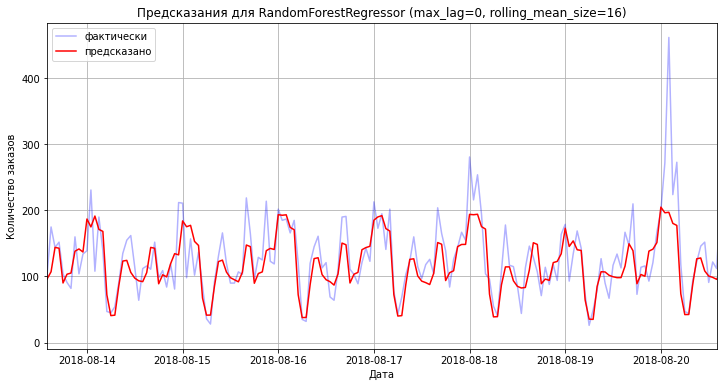

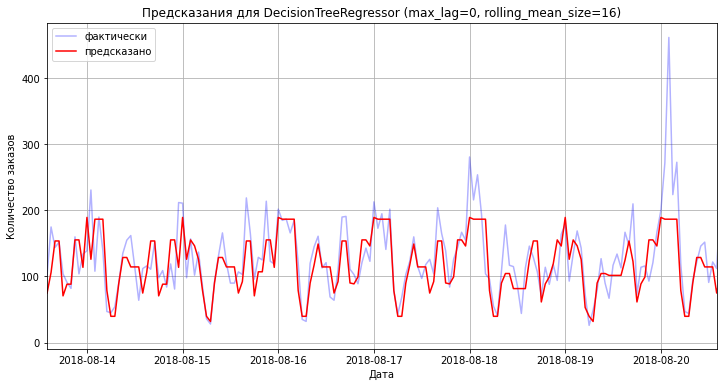

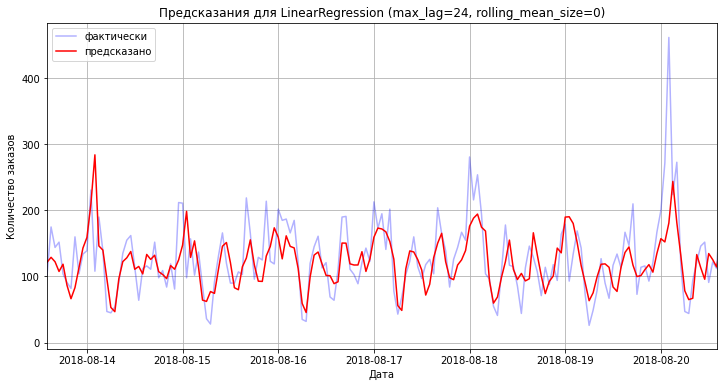

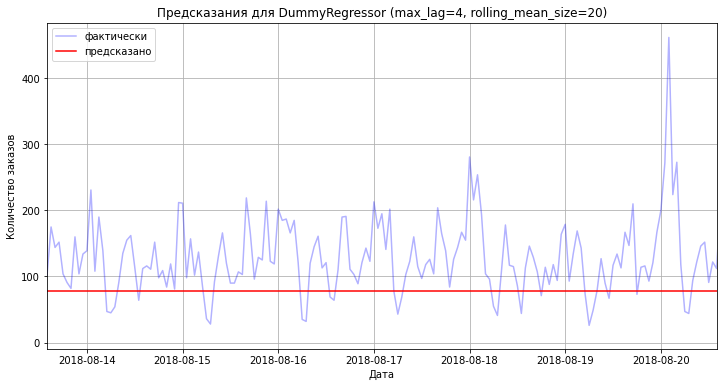

In [58]:
for index, row in best_results_by_model.iterrows():
    features_train, target_train, features_test, target_test = prepare_train_test_data(df_1H,
                                                           row['max_lag'], 
                                                           row['rolling_mean_size']
                                                          )
    model = row['Модель']
    title = 'Предсказания для {} (max_lag={}, rolling_mean_size={})'.format(row['Название модели'], row['max_lag'], row['rolling_mean_size'])
    
    plot_fact_predict_comparison(title, 
                                 target_test.index, 
                                 target_test, 
                                 model.predict(features_test))

Модели плохо предсказывают пики нагрузок

In [59]:
def plot_rmse_by_features_stucture(model_name, max_lag_array, rolling_mean_size_array, rmse_array):
    x = max_lag_array
    y = rolling_mean_size_array
    z = rmse_array

    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)
    surf = ax.plot_trisurf(x, y, z, cmap=cm.summer, linewidth=0.2)

    fig.suptitle('Метрики для различных конфигураций выборки ({})'.format(model_name), fontsize=16)
    ax.set_xlabel('max_lag', fontsize=10)
    ax.set_ylabel('rolling_mean_size', fontsize=10)
    ax.set_zlabel('RMSE', fontsize=10)

    # optional view configurations
    ax.elev = 30
    ax.azim = 135

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()

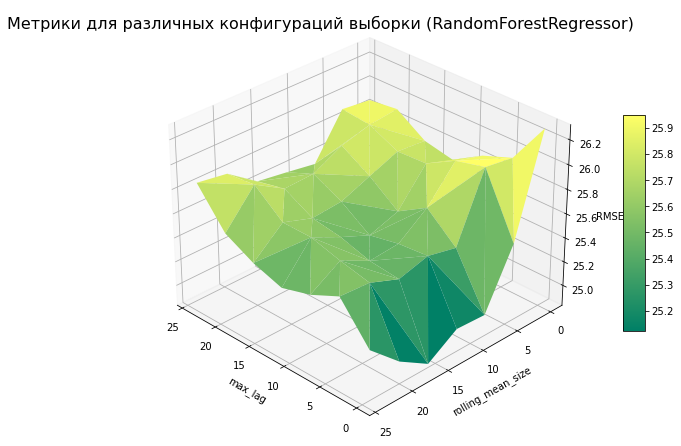

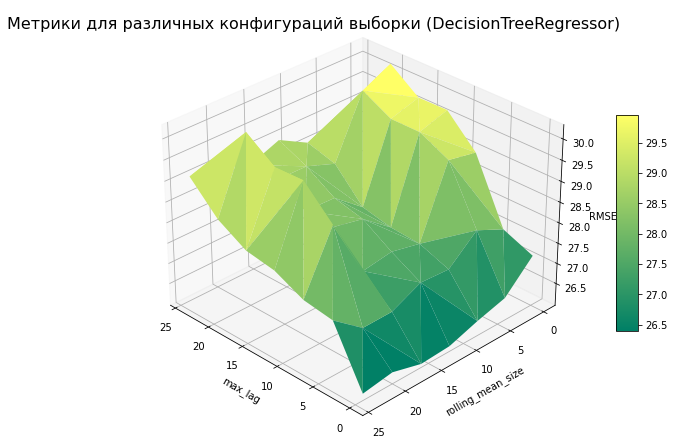

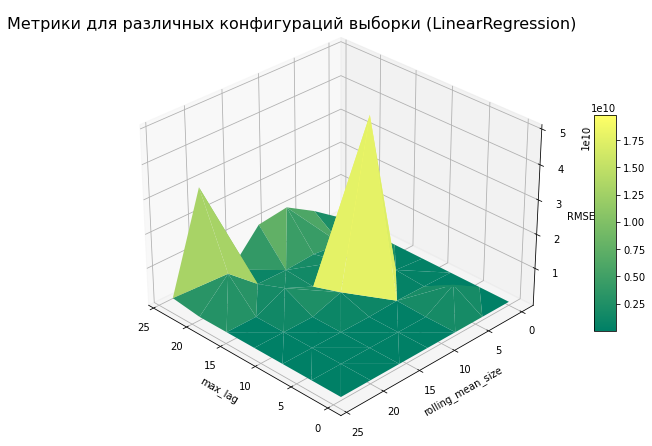

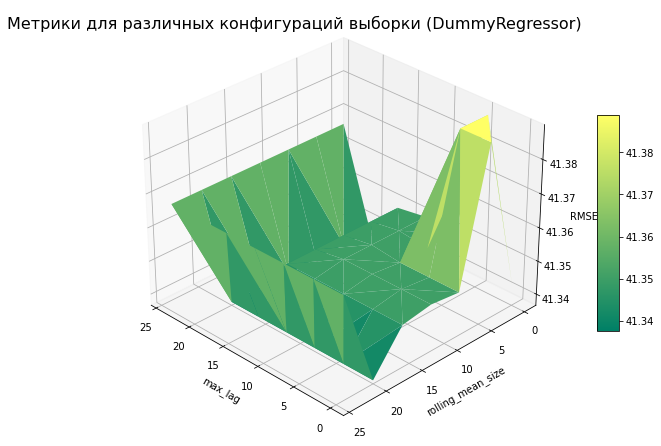

In [60]:
model_list = ['RandomForestRegressor', 'DecisionTreeRegressor', 'LinearRegression', 'DummyRegressor']

for model in model_list:

    res_df = models_train_results_df[models_train_results_df['Название модели']==model][[
        'max_lag', 'rolling_mean_size', 'RMSE (валидационная выборка)']]
    
    plot_rmse_by_features_stucture(model, 
                                   np.array(res_df.max_lag), 
                                   np.array(res_df.rolling_mean_size), 
                                   np.array(res_df['RMSE (валидационная выборка)']))


### Вывод

Мы подобрали конфигурацию выборки с дополнительными признаками, получив модель с наилучшими метриками.  

    - max_lag=0, rolling_mean_size=16

Наилучший результат с удовлетворительной метрикой (<=48 для тестовой) у RandomForestRegressor

    - rmse (валидационная) = 24.86			
    - rmse (тестовая) = 44.35

Остальные модели показали близкие результаты. И все они значительно лучше оценки предыдущим значением:
     
    - rmse (тестовая) = 58.86

Зависимости метрик от конфигурации выборки  можно увидеть на рисунках. Минимумы у моделей RandomForestRegressor и DecisionTreeRegressor в одной области. В остальном все модели ведут себя по разному. Трудно объяснить выбросы у линейной регрессии.

Линейная регрессия лучше обучается при большем количестве признаков,  в то время как у RandomForestRegressor и DecisionTreeRegressor, наоборот, большее значение имеет скользящее среднее.  
